In [161]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
import statsmodels.tools.eval_measures as em
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import yfinance as yf
from statsmodels.tsa.stattools import grangercausalitytests

# #This is a VAR analysis of the Biotechnology company BIIB 

In [118]:
# The Basic Process of the following codes: 
# S1: specify the variables inside the VAR model
# S2: check stationarity (ADF test)
# S3: check the order for VAR analysis using metrics of aic and bic
# S4: test-train split
# S5: Fit the VAR model
# S6: Draw the forecast
# S7: Conclusion

In [301]:
tickers_list = ['^GSPC','^IRX','IBB','^VIX','PFE','JNJ']
data = yf.download(tickers_list,'2019-02-01', '2023-10-20')['Adj Close']
m_data = data.groupby(data.index.to_period('M')).first()
print(m_data.tail())

[*********************100%%**********************]  6 of 6 completed
                IBB         JNJ        PFE        ^GSPC   ^IRX       ^VIX
Date                                                                     
2023-06  126.605476  153.426041  37.601078  4221.020020  5.203  15.650000
2023-07  126.651314  162.172546  36.246174  4455.589844  5.145  13.570000
2023-08  127.889771  167.672607  35.610001  4576.729980  5.260  13.930000
2023-09  129.847305  160.479996  35.779999  4515.770020  5.268  13.090000
2023-10  120.639999  155.149994  33.939999  4288.390137  5.315  17.610001


In [345]:
tickers_list = ['^GSPC','^IRX','IBB','^VIX','PFE','JNJ','IHE']
data = yf.download(tickers_list,'2013-01-01', '2023-10-20')['Adj Close']
m_data = data.groupby(data.index.to_period('M')).first()
print(m_data.head())

[*********************100%%**********************]  7 of 7 completed
               IBB        IHE        JNJ        PFE        ^GSPC   ^IRX   ^VIX
Date                                                                          
2013-01  46.244904  73.989349  52.788971  16.662193  1462.420044  0.055  14.68
2013-02  48.253147  78.585335  55.277878  17.923586  1513.170044  0.060  12.90
2013-03  48.840908  79.338501  57.612961  17.767899  1518.199951  0.100  15.36
2013-04  52.103081  82.002724  61.541439  18.708511  1562.170044  0.065  13.58
2013-05  55.894226  83.256248  63.269100  18.747435  1582.699951  0.050  14.49


All othe stocks and indicators have more than 120 data points, should MRNA be excluded?


In [302]:
# tickers_list = ['^GSPC','^IRX']
# data = yf.download(tickers_list,'2019-02-01', '2023-10-20')['Adj Close']
# m_data = data.groupby(data.index.to_period('M')).first()
# print(m_data.tail())

In [346]:
data = pd.read_csv('/Users/wangmeiyi/Desktop/100dataset/MRNA-3.csv', index_col = 0)
data=data.drop(['Open','High','Low','Close','Volume'], axis = 'columns')
data['MRNA'] = data['Adj Close']
data = data.drop(['Adj Close'], axis = 'columns')

In [308]:
data['SNP'] = m_data['^GSPC']
data['TB'] = m_data['^IRX']
data['IBB'] = m_data['IBB']
data['VIX'] = m_data['^VIX']
data['PFE'] = m_data['PFE']
data['JNJ'] = m_data['JNJ']

In [309]:
CPI = pd.read_csv('/Users/wangmeiyi/Desktop/100dataset/CPIAUCSL-2.csv', index_col = 0)
data['CPI'] = CPI['CPIAUCSL']

In [310]:
data.tail()

,MRNA,SNP,TB,CPI,IBB,VIX,PFE,JNJ
Date,,,,,,,,
2023-07-01,117.660004,4455.589844,5.145,304.348,126.651314,13.570000,36.246174,162.172546
2023-08-01,113.070000,4576.729980,5.260,306.269,127.889771,13.930000,35.610001,167.672607
2023-09-01,103.290001,4515.770020,5.268,307.481,129.847305,13.090000,35.779999,160.479996
2023-10-01,80.400002,4288.390137,5.315,NaN,120.639999,17.610001,33.939999,155.149994
2023-10-20,80.400002,4288.390137,5.315,NaN,120.639999,17.610001,33.939999,155.149994


In [311]:
def Log_diff(x):
    x_diff = 100 * np.log(x/x.shift(1))
    x_diff = x_diff.dropna()
    return x_diff

In [312]:
data = Log_diff(data)

In [313]:
len(data)

55

In [314]:
data = data.head(55)

In [315]:
data.tail()

,MRNA,SNP,TB,CPI,IBB,VIX,PFE,JNJ
Date,,,,,,,,
2023-05-01,-3.975965,1.045797,6.255343,0.124049,1.354720,-14.289349,-5.314063,4.213444
2023-06-01,-4.984780,1.267167,6.716873,0.180191,-3.693651,-2.710537,-2.005673,-4.945482
2023-07-01,-3.211512,5.408264,-1.121003,0.166725,0.036198,-14.260944,-3.669889,5.544224
2023-08-01,-3.979205,2.682531,2.210570,0.629202,0.973098,2.618336,-1.770731,3.335244
2023-09-01,-9.046652,-1.340905,0.151974,0.394950,1.519046,-6.219622,0.476253,-4.384402


In [316]:
data.describe()

,MRNA,SNP,TB,CPI,IBB,VIX,PFE,JNJ
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,2.762892,0.930742,1.475454,0.352276,0.318111,-0.380822,0.073992,0.556730
std,22.609770,5.796376,56.059444,0.334857,6.223021,28.794141,7.853832,4.830889
min,-40.540602,-22.382496,-289.125318,-0.790333,-13.974090,-62.844801,-14.842017,-8.344689
25%,-10.993598,-2.157216,-5.611293,0.171545,-3.890646,-18.381357,-5.400919,-2.992953
50%,2.069910,1.948672,1.610891,0.369323,0.973098,-1.260677,-1.392506,0.926540
75%,14.369266,4.618573,24.137827,0.494302,4.168765,17.796471,3.991619,3.793536
max,81.705409,13.610699,138.629436,1.180909,15.259406,63.995983,23.426328,14.083121


In [317]:
print(data.columns)

Index(['MRNA', 'SNP', 'TB', 'CPI', 'IBB', 'VIX', 'PFE', 'JNJ'], dtype='object')


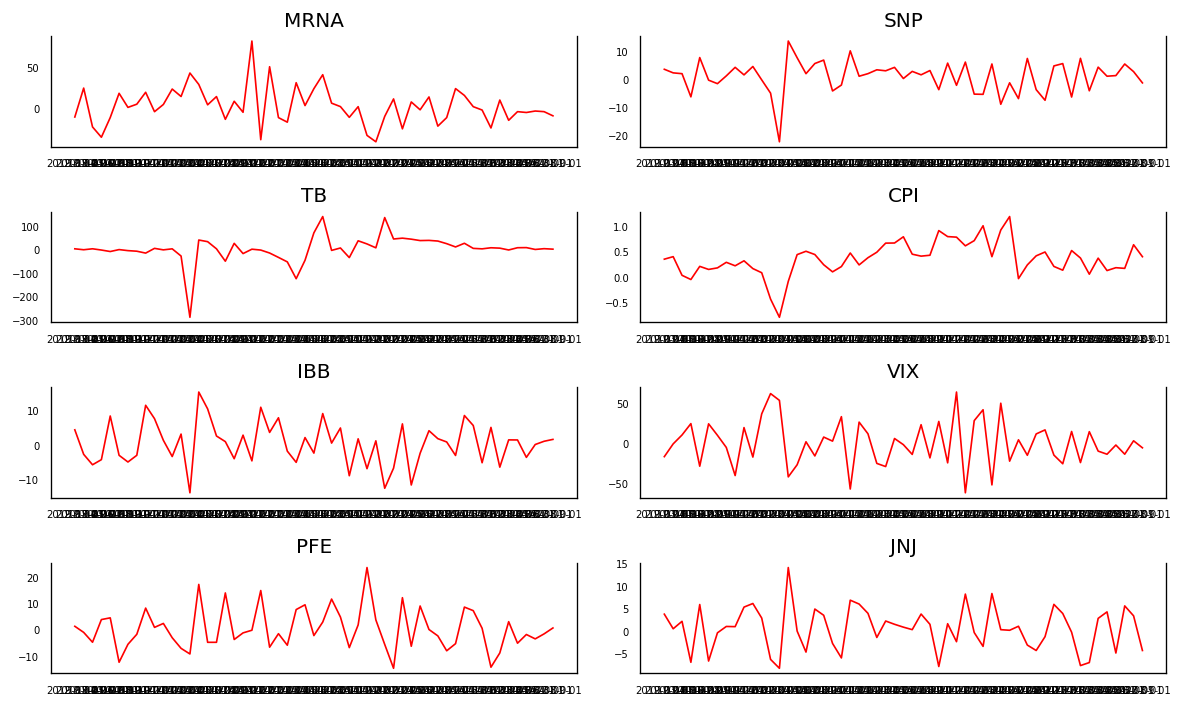

In [319]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))

for i, ax in enumerate(axes.flatten()):
    
    data1 = data[data.columns[i]]
    ax.plot(data1, color='red', linewidth=1)
    # Decorations
    ax.set_title(data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [320]:
# # 2SLS, specification 2
# ivmod = IV2SLS(dependent = data.rsandp,
#                exog = data['SNP','TB','CPI'],
#                endog = data.inflation,
#                instruments = data[['rterm','dspread']])
# res_2sls2 = ivmod.fit(cov_type='unadjusted')
# print(res_2sls2)

# # ADF test

In [321]:
print(data.columns)

Index(['MRNA', 'SNP', 'TB', 'CPI', 'IBB', 'VIX', 'PFE', 'JNJ'], dtype='object')


In [323]:
columns = ['MRNA', 'SNP', 'TB', 'CPI','IBB', 'VIX', 'PFE', 'JNJ']
for column in columns:
    result = adfuller(data[f'{column}'])
    print(f'{column}'':')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

MRNA:
ADF Statistic: -4.092907
p-value: 0.000995
SNP:
ADF Statistic: -8.944780
p-value: 0.000000
TB:
ADF Statistic: -5.918357
p-value: 0.000000
CPI:
ADF Statistic: -3.804705
p-value: 0.002860
IBB:
ADF Statistic: -8.160027
p-value: 0.000000
VIX:
ADF Statistic: -1.795763
p-value: 0.382567
PFE:
ADF Statistic: -6.806829
p-value: 0.000000
JNJ:
ADF Statistic: -7.523208
p-value: 0.000000


Stationary Test for both two variables passed given p-values of both varaibles are nearly 0

In [324]:
# ivmod = IV2SLS(dependent = data.inflation,
#                exog = data[['const','dprod','dcredit','dmoney']],
#                endog = data.rsandp,
#                instruments = data[['rterm','dspread']])
# res_2sls1 = ivmod.fit(cov_type='unadjusted')
# print(res_2sls1)

# # Test Train Split

In [325]:
data.shape

(55, 8)

In [340]:
test_obs = 9
train = data[:-test_obs]
test = data[-test_obs:]

# we split the train and test observations. 
# Test observations are the data in this year, the rest: Train

In [327]:
test.tail()

,MRNA,SNP,TB,CPI,IBB,VIX,PFE,JNJ
Date,,,,,,,,
2023-05-01,-3.975965,1.045797,6.255343,0.124049,1.354720,-14.289349,-5.314063,4.213444
2023-06-01,-4.984780,1.267167,6.716873,0.180191,-3.693651,-2.710537,-2.005673,-4.945482
2023-07-01,-3.211512,5.408264,-1.121003,0.166725,0.036198,-14.260944,-3.669889,5.544224
2023-08-01,-3.979205,2.682531,2.210570,0.629202,0.973098,2.618336,-1.770731,3.335244
2023-09-01,-9.046652,-1.340905,0.151974,0.394950,1.519046,-6.219622,0.476253,-4.384402


# #VAR model

In [328]:
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  31.190175029102036
BIC:  34.080835012734546

Order = 2
AIC:  32.134831673787296
BIC:  37.649599633171015

Order = 3
AIC:  30.927779688640975
BIC:  39.11940813372731

Order = 4
AIC:  23.06149131957778
BIC:  33.98398606307324

Order = 5
AIC:  -inf
BIC:  -inf

Order = 6
AIC:  -471.3854398023943
BIC:  -454.8344211520777

Order = 7
AIC:  -477.23620962504583
BIC:  -457.78533499337607

Order = 8
AIC:  -465.17622523201896
BIC:  -442.7671514673421

Order = 9
AIC:  -469.0323081425754
BIC:  -443.6059281159747

Order = 10
AIC:  -466.4854943874488
BIC:  -437.98215349523883



/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency in

In [329]:
result = model.fit(4)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 24, Oct, 2023
Time:                     15:09:14
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    33.9840
Nobs:                     42.0000    HQIC:                   27.0650
Log likelihood:          -697.055    FPE:                8.36231e+11
AIC:                      23.0615    Det(Omega_mle):     8.08780e+09
--------------------------------------------------------------------
Results for equation MRNA
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -4.191123        10.105795           -0.415           0.678
L1.MRNA         0.146940         0.204056            0.720           0.471
L1.SNP         -2.842001         1.499531           -1.895           0.058
L1.TB     

# # Causality Test

In [330]:
Causality = result.test_causality(causing=['MRNA'],
                                 caused=['SNP'],
                                 kind='wald',signif=0.1 )
print(Causality)

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: MRNA does not Granger-cause SNP: fail to reject at 10% significance level. Test statistic: 4.544, critical value: 7.779>, p-value: 0.337>


# # Granger Causality Test

In [331]:
from statsmodels.tsa.stattools import grangercausalitytests

#perform Granger-Causality test & reverse test
grangercausalitytests(data[['MRNA', 'SNP']], maxlag=[4])


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7886  , p=0.5391  , df_denom=42, df_num=4
ssr based chi2 test:   chi2=3.8303  , p=0.4295  , df=4
likelihood ratio test: chi2=3.6933  , p=0.4491  , df=4
parameter F test:         F=0.7886  , p=0.5391  , df_denom=42, df_num=4


{4: ({'ssr_ftest': (0.7885977643991183, 0.5391470956716831, 42.0, 4),
   'ssr_chi2test': (3.830331998510003, 0.42945460556122206, 4),
   'lrtest': (3.693313497998531, 0.44909918491000744, 4),
   'params_ftest': (0.7885977643991178, 0.5391470956716831, 42.0, 4.0)},
   array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}

In [332]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    data = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in data.columns:
        for r in data.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=4, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            data.loc[r, c] = min_p_value
    data.columns = [var + '_x' for var in variables]
    data.index = [var + '_y' for var in variables]
    return data

grangers_causation_matrix(data, variables = data.columns)

/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ValueError: Insufficient observations. Maximum allowable lag is 1

# # Impulse Responses

In [1]:
model = smt.VAR(train)
res = model.fit(maxlags=1)
# Impulse Response Analysis
irf = res.irf(20)

irf.plot()

NameError: name 'smt' is not defined

# # Forecast Error Variance Decomposition

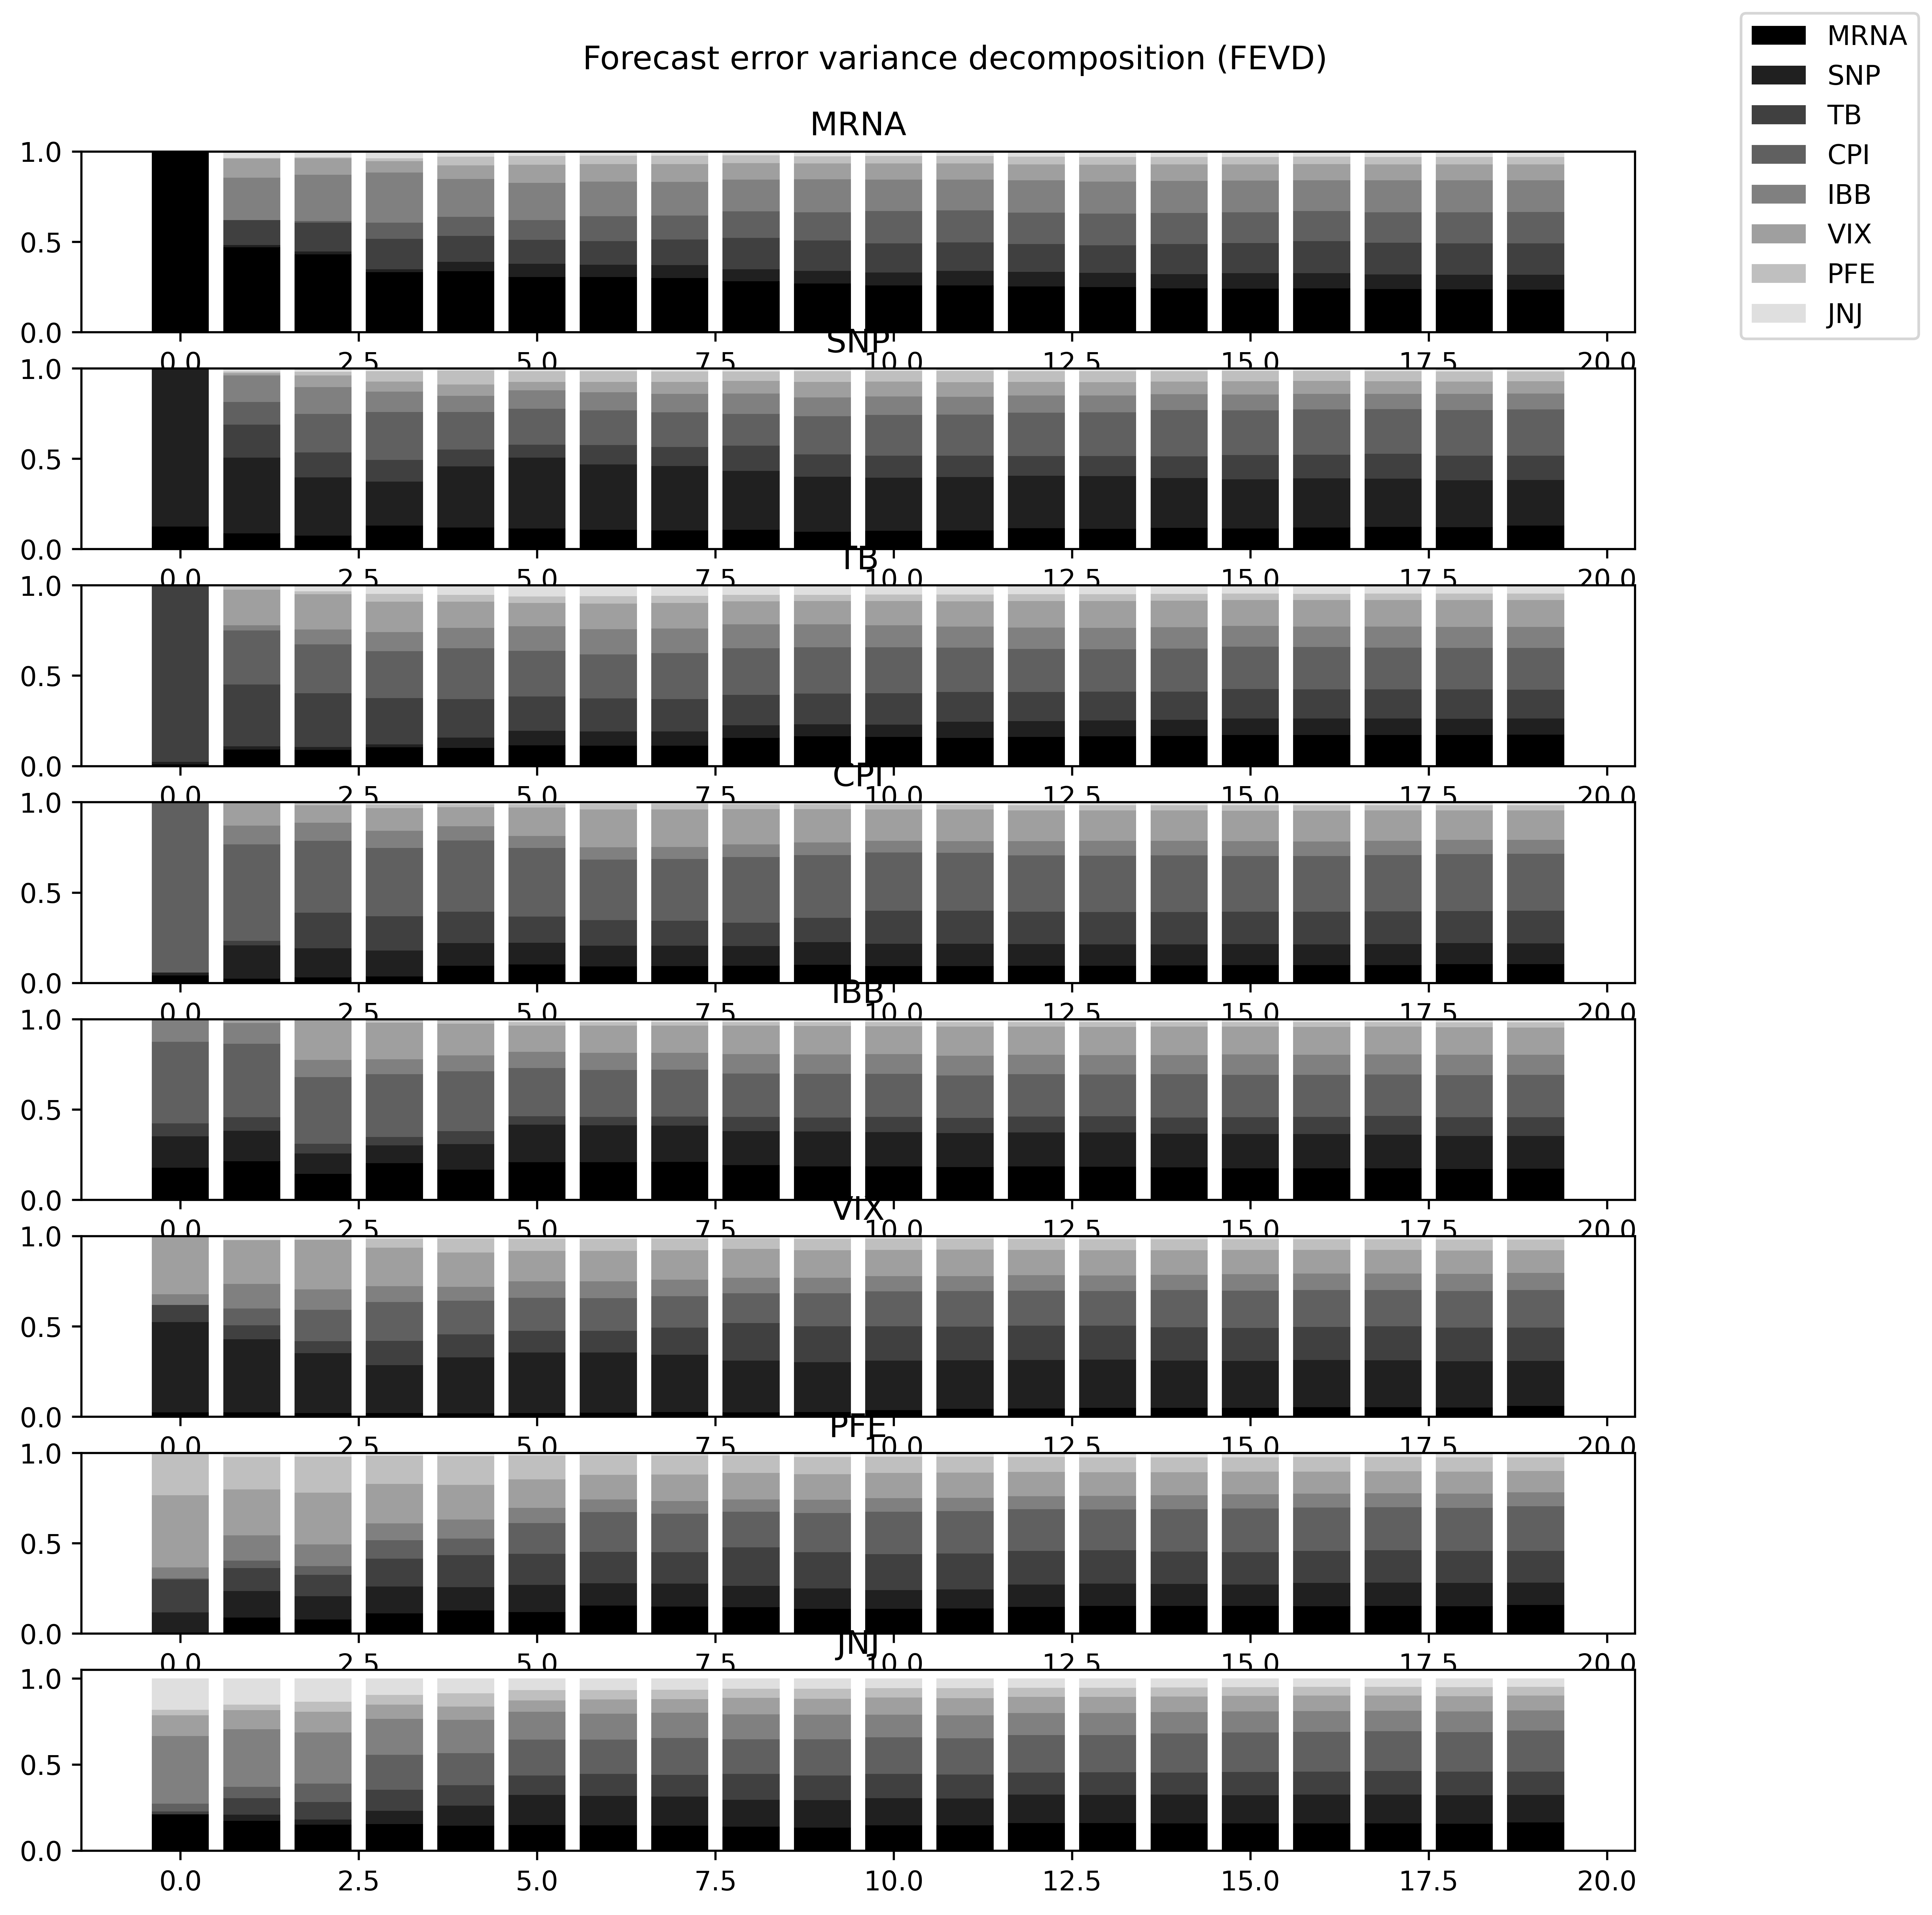

In [334]:
fevd = result.fevd(20)
fig = fevd.plot()
fig.set_dpi(600)
plt.show()

# #FORECAST

In [335]:
lag_order = result.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = data.values[-lag_order:]
forecast_input

4


array([[ -4.98477979,   1.26716676,   6.71687269,   0.18019062,
         -3.69365071,  -2.71053664,  -2.00567278,  -4.94548197],
       [ -3.21151193,   5.40826429,  -1.12100299,   0.16672453,
          0.03619836, -14.26094413,  -3.66988941,   5.54422385],
       [ -3.97920475,   2.68253125,   2.21057047,   0.62920172,
          0.97309753,   2.61833583,  -1.77073126,   3.33524432],
       [ -9.04665202,  -1.34090458,   0.15197375,   0.3949496 ,
          1.51904605,  -6.21962181,   0.47625295,  -4.38440152]])

In [336]:
nobs = 9
fc = result.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=data.index[-nobs:], columns=data.columns + '_2d')
df_forecast

,MRNA_2d,SNP_2d,TB_2d,CPI_2d,IBB_2d,VIX_2d,PFE_2d,JNJ_2d
Date,,,,,,,,
2023-01-01,-46.668798,8.340794,-62.258753,0.645554,-1.241879,-64.180018,11.090600,8.170403
2023-02-01,34.939099,9.024842,84.223688,0.561021,0.456796,3.511682,-4.099001,5.010683
2023-03-01,-11.240819,-9.223820,6.153316,0.382403,-4.710909,57.135366,-10.554398,-7.371202
2023-04-01,52.257196,-6.179530,-2.418490,-0.125153,-3.180441,4.504546,-7.471408,-0.882211
2023-05-01,26.528919,1.778119,-43.667223,0.033247,5.899972,-13.400022,18.993526,6.971787
2023-06-01,20.280925,4.785175,-3.157122,0.311426,10.123416,-0.305142,-1.453498,3.354022
2023-07-01,0.614399,-2.788332,-12.403347,0.416597,3.372952,-14.672391,-7.666440,-2.502558
2023-08-01,28.105263,4.194707,15.628584,0.394148,1.332251,19.143264,-2.172685,-0.557461
2023-09-01,-36.158771,8.883124,-85.900848,0.223920,4.745822,-31.033810,15.200303,3.464737


In [337]:
data.columns

Index(['MRNA', 'SNP', 'TB', 'CPI', 'IBB', 'VIX', 'PFE', 'JNJ'], dtype='object')

In [341]:
def invert_transformation(test, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = test.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (test[col].iloc[-1]-train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = test[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(test, df_forecast, second_diff=True)        
df_results.loc[:, ['MRNA_forecast','SNP_forecast', 'TB_forecast', 'CPI_forecast']]

,MRNA_forecast,SNP_forecast,TB_forecast,CPI_forecast
Date,,,,
2023-01-01,-80.476066,0.941953,-87.086250,1.230620
2023-02-01,-116.966380,12.249651,-90.100786,2.627312
2023-03-01,-164.697514,14.333530,-86.962005,4.406407
2023-04-01,-160.171452,10.237879,-86.241714,6.060349
2023-05-01,-129.116470,7.920347,-129.188647,7.747538
2023-06-01,-77.780563,10.387990,-175.292701,9.746153
2023-07-01,-25.830258,10.067302,-233.800102,12.161365
2023-08-01,54.225311,13.941321,-276.678920,14.970725
2023-09-01,98.122109,26.698464,-405.458586,18.004005


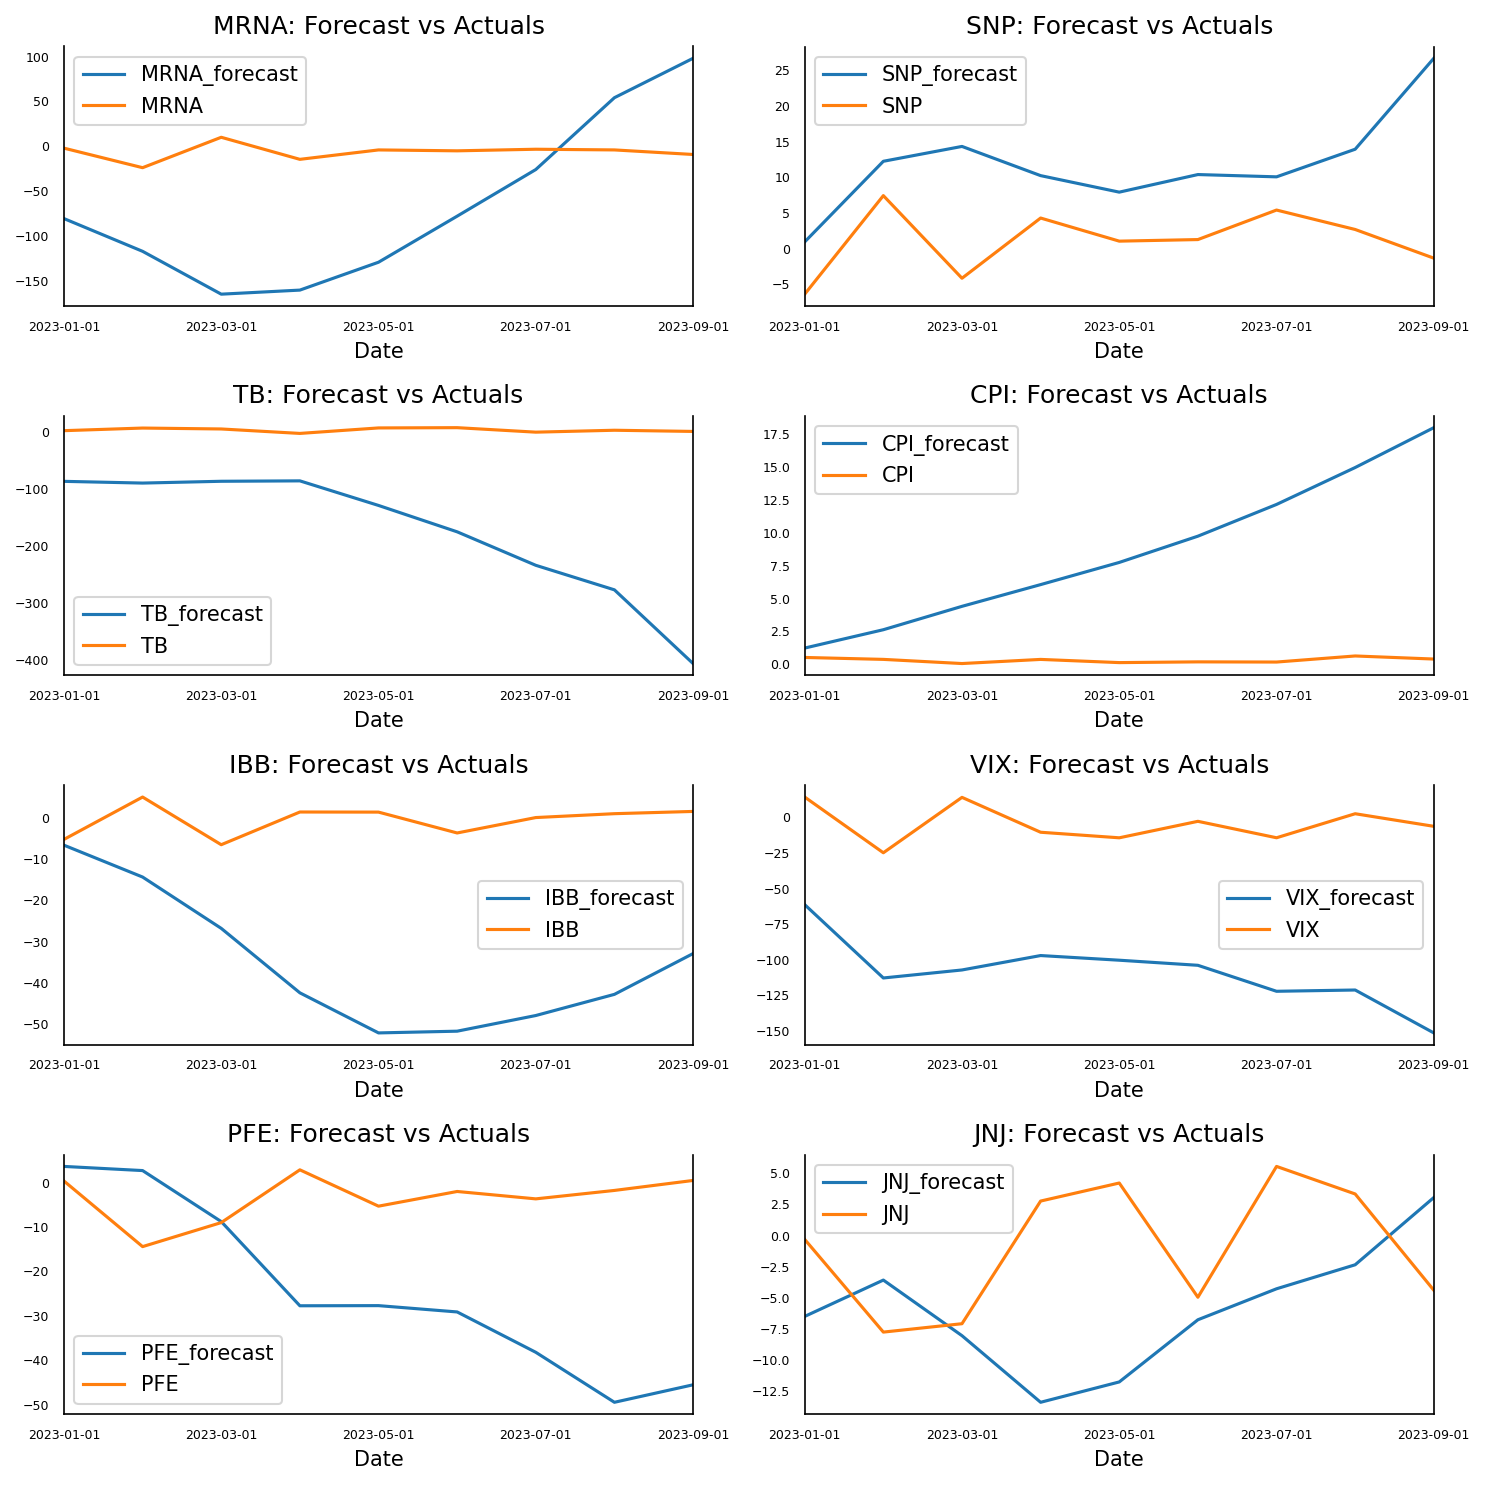

In [342]:
fig, axes = plt.subplots(nrows=int(len(data.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test[col][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();